In [1]:
import pandas as pd 
import numpy as np 
import os 
import gc 
import random 
from catboost import CatBoostRanker, Pool 
import joblib 
from pathlib import Path
from tqdm.notebook import tqdm 
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
from sklearn.decomposition import PCA 
import polars as pl 

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [2]:
class Setup: 
    MAIN_DIR = Path('/Users/ilagulakin/Desktop/AI & code/NTO 2025/command/command_data/')
    TRAIN = 'train.csv'
    USERS = 'users.csv'
    TARGETS = 'targets.csv'
    SAMPLE_SUBMISSION = 'sample_submission.csv'
    CANDIDATES = 'candidates.csv'
    BOOKS = 'books.csv'
    BOOK_GENRES = 'book_genres.csv'
    BOOK_DESCRIPTIONS = 'book_descriptions.csv'
    GENRES = 'genres.csv'
    TFIDF = 'tfidf.pkl'
    PCA = 'pca.pkl'
    

In [3]:
class Cfg: 
    SEED = 42 
    MISS = -1 
    MAX_RANKING_LENGTH = 20 
    MAX_HISTORY = 100 
    SPLIT = 0.8 
    EARLY_STOPPING = 100

    TF_MAX = 90
    TF_MIN_DF = 2
    TF_MAX_DF = 0.95
    TF_NGRAMM = 1

    TEMPORAL_SPLIT_RATIO = 0.8 # разделяем данные по времени!
    CAT = {
        'loss_function': 'YetiRank', 
        'eval_metric': 'NDCG:top=20',
        'iterations': 5000, 
        'learning_rate': .03, 
        'depth': 12, 
        'random_state': SEED, 
        'task_type': 'CPU', 
        'early_stopping_rounds': EARLY_STOPPING, 
        'verbose': 300
    }

In [4]:
def seed_everything(seed): 
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) 

seed_everything(Cfg.SEED)

In [5]:
def expand_candidates(candidates_df):
    rows = []
    for _, row in candidates_df.iterrows():
        if pd.isna(row['book_id_list']) or not row['book_id_list'].strip():
            continue
            
        books = [int(x.strip()) for x in row['book_id_list'].split(",") if x.strip()]
        for book in books:
            rows.append({'user_id': row['user_id'], 'book_id': book})
            
    return pd.DataFrame(rows).astype({'user_id': "int32", 'book_id': "int32"})

Feature engineering

In [6]:
def add_interaction_feature(df, train_df):
    pairs = set(zip(train_df['user_id'], train_df['book_id']))
    df['user_book_interaction'] = [
        1 if (u, b) in pairs else 0
        for u, b in zip(df['user_id'], df['book_id'])
    ]
    return df


In [7]:
def add_text_features(texts): 
    if (Setup.MAIN_DIR / Setup.TFIDF).exists():
        vectorizer = joblib.load(str(Setup.MAIN_DIR / Setup.TFIDF))
    
    else:
        vectorizer = TfidfVectorizer(
            max_features=Cfg.TF_MAX, 
            min_df=Cfg.TF_MIN_DF, 
            max_df=Cfg.TF_MAX_DF, 
            n_gram_range=Cfg.TF_NGRAMM
        )
        vectorizer.fit(texts)
        joblib.dump(vectorizer, str(Setup.MAIN_DIR / Setup.TFIDF))

    embeddings = vectorizer.transform(texts)
    
    if (Setup.MAIN_DIR / Setup.PCA).exists():  
        pca =  joblib.load(str(Setup.MAIN_DIR / Setup.PCA))
    else: 
        pca = PCA(n_components=64)
        pca.fit(embeddings)

    embeddings = pca.transform(embeddings)
    embeddings = np.vstack(embeddings)
    
    return list(embeddings)

# Жанровые признаки для рекомендации книг

В этом ноутбуке используются признаки, описывающие связь **пользователь – книга – жанры**.  
Цель этих признаков — зафиксировать как **объективные свойства книги**, так и **персональные жанровые предпочтения пользователя**.

---

## Используемые данные

- `book_genres_df`: соответствие *книга → жанр*
- `train`: история взаимодействий *(user, book, relevance)*
- `df`: датасет пар *(user, book)*, для которых строятся признаки

---

## 1. `f_book_genres_count`

**Описание:**  
Количество жанров, присвоенных книге.

**Как считается:**  
Для каждой книги считается число жанров в `book_genres_df`.

**Формула:**
$$
f\_book\_genres\_count(b) = |G(b)|
$$

где:
- $G(b)$ — множество жанров книги $b$

**Интуиция:**

- Книги с малым числом жанров обычно более нишевые
- Книги с большим числом жанров — более универсальные
- Признак помогает модели учитывать «ширину» аудитории книги

**Тип признака:** book-level

---

## 2. `book_genre_global_mean_avg`

**Описание:**  
Средняя глобальная релевантность жанров книги.

**Как считается:**

1. Для каждого жанра считается средняя релевантность по всем пользователям:
$$
\mu_g = \mathbb{E}[\text{relevance} \mid genre = g]
$$

2. Для книги берётся среднее по всем её жанрам:
$$
book\_genre\_global\_mean\_avg(b) =
\frac{1}{|G(b)|} \sum_{g \in G(b)} \mu_g
$$

**Интуиция:**

- Отражает, насколько жанры книги «хороши в среднем»
- Не зависит от конкретного пользователя
- Особенно полезен при холодном старте пользователя

**Тип признака:** book-level

---

## 3. `user_genre_weighted_mean_sum`

**Описание:**  
Взвешенная оценка того, насколько жанры книги соответствуют предпочтениям пользователя.

---

### 3.1 User–Genre статистики

Для каждой пары *(user, genre)* из обучающей выборки считаются:

- `user_genre_cnt(u, g)` — количество взаимодействий пользователя с жанром
- `user_genre_mean_rel(u, g)` — средняя релевантность пользователя к жанру

$$
\text{mean\_rel}(u,g) = \mathbb{E}[\text{relevance} \mid u, g]
$$

---

### 3.2 Жанровые веса внутри книги

Для книги \(b\) и пользователя \(u\) вводится вес жанра:

$$
w(u, g \mid b) =
\frac{\text{cnt}(u,g)}
{\sum_{g' \in G(b)} \text{cnt}(u,g') + \varepsilon}
$$

где:
- $\varepsilon$ — малое число для численной устойчивости

`user_genre_count = (train_ug.groupby(['user_id', 'genre_id'])['relevance']`\
`.agg(["count"]).reset_index().rename(columns={"count": "user_genre_cnt"}))`

`denom = tmp.groupby(['user_id', 'book_id'])["user_genre_cnt"].transform("sum")`\
`tmp["user_genre_w"] = tmp["user_genre_cnt"] / (denom + eps)`

**Смысл веса:**

- Отражает относительную важность жанра для пользователя
- Нормировка происходит **только по жанрам текущей книги**
- Если пользователь никогда не взаимодействовал с жанрами книги — все веса равны 0

---

### 3.3 Итоговая формула признака

$$
user\_genre\_weighted\_mean\_sum(u,b) =
\sum_{g \in G(b)} w(u,g \mid b) \cdot \text{mean\_rel}(u,g)
$$

**Интуиция:**

- Признак показывает, насколько книга жанрово совпадает с интересами пользователя
- Учитывает:
  - силу предпочтения пользователя к жанру
  - относительную значимость жанра внутри книги
- Является ключевым персонализированным сигналом

**Тип признака:** user–book-level

---

## Сводная таблица признаков

| Признак | Уровень | Смысл |
|------|------|------|
| `f_book_genres_count` | book | Ширина и универсальность книги |
| `book_genre_global_mean_avg` | book | Средняя популярность жанров книги |
| `user_genre_weighted_mean_sum` | user–book | Персональная жанровая релевантность |


In [8]:
def add_genre_features(df, book_genres, train): 
    eps = 1e-6
    genre_counts = book_genres.groupby('book_id')['genre_id'].count().reset_index()
    genre_counts.columns = ['book_id', 'book_genres_count']
    out = df.merge(genre_counts, on='book_id', how='left') 

    # train с жанрами
    train_ug = train[['user_id', 'book_id', 'relevance']].merge(
        book_genres[['book_id', 'genre_id']], on='book_id', how="left",
    )

    # user-genre stats: mean relevance + count interactions
    user_genre_stats = (
        train_ug.groupby(['user_id', 'genre_id'])['relevance']
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={"mean": "user_genre_mean_rel", "count": "user_genre_cnt"})
    )

    # global genre mean relevance
    genre_global_mean = (
        train_ug.groupby('genre_id')['relevance']
        .mean()
        .reset_index()
        .rename(columns={'relevance': "genre_global_mean_rel"})
    )

    # для каждой книги: среднее глобальных средних по её жанрам
    book_genre_global_mean = (
        book_genres.merge(genre_global_mean, on='genre_id', how="left")
        .groupby('book_id')["genre_global_mean_rel"]
        .mean()
        .reset_index()
        .rename(columns={"genre_global_mean_rel": "book_genre_global_mean_avg"})
    )
    out = out.merge(book_genre_global_mean, on='book_id', how="left")

    # развернуть (user, book) -> (user, book, genre)
    tmp = out[['user_id', 'book_id']].merge(
        book_genres[['book_id', 'genre_id']],
        on='book_id',
        how="left",
    )

    # приклеить user-genre stats (если жанр не встречался у пользователя -> 0)
    tmp = tmp.merge(
        user_genre_stats,
        on=['user_id', 'genre_id'],
        how="left",
    )
    tmp["user_genre_cnt"] = tmp["user_genre_cnt"].fillna(0).astype("float32")
    tmp["user_genre_mean_rel"] = tmp["user_genre_mean_rel"].fillna(0).astype("float32")

    # веса по жанрам внутри конкретной книги
    denom = tmp.groupby(['user_id', 'book_id'])["user_genre_cnt"].transform("sum")
    tmp["user_genre_w"] = tmp["user_genre_cnt"] / (denom + eps)

    # итоговая фича: взвешенная сумма mean_rel
    tmp["wg_component"] = tmp["user_genre_w"] * tmp["user_genre_mean_rel"]

    feat = (
        tmp.groupby(['user_id', 'book_id'])["wg_component"]
        .sum()
        .reset_index()
        .rename(columns={"wg_component": "user_genre_weighted_mean_sum"})
    )

    out = out.merge(feat, on=['user_id', 'book_id'], how="left")

    # fillna/types
    out['book_genres_count'] = out['book_genres_count'].fillna(0).astype("int16")
    out["user_genre_weighted_mean_sum"] = out["user_genre_weighted_mean_sum"].fillna(0).astype("float32")
    out["book_genre_global_mean_avg"] = out["book_genre_global_mean_avg"].fillna(0).astype("float32")

    return out

In [9]:
def add_aggregate_features(df, train):
    eps = 1e-6

    # базовые агрегаты (+ std)
    user_agg = (
        train.groupby('user_id')['relevance']
        .agg(["mean", "count", "std"])
        .reset_index()
    )
    user_agg.columns = ['user_id', "user_relevance_mean", "user_relevance_count", "user_relevance_std"]

    book_agg = (
        train.groupby('book_id')['relevance']
        .agg(["mean", "count", "std"])
        .reset_index()
    )
    book_agg.columns = ['book_id', "book_relevance_mean", "book_relevance_count", "book_relevance_std"]

    # Расчитаем сколько книг для пользователя имют конкрентую релевантность (активность пользователя)
    user_counts = (
        train.pivot_table(
            index='user_id',
            columns='relevance',
            values='book_id',
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "user_count1", 2: "user_count2"})
        .reset_index()
    )
    for c in ["user_count1", "user_count2"]:
        if c not in user_counts.columns:
            user_counts[c] = 0

    user_counts["user_total"] = user_counts["user_count1"] + user_counts["user_count2"]
    user_counts["user_share1"] = user_counts["user_count1"] / (user_counts["user_total"] + eps)
    user_counts["user_share2"] = user_counts["user_count2"] / (user_counts["user_total"] + eps)

    # для каждой книги смотрим какое количество пользователей имеет для этой книги какую релевантность 
    book_counts = (
        train.pivot_table(
            index='book_id',
            columns='relevance',
            values='user_id',
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "book_count1", 2: "book_count2"})
        .reset_index()
    )
    for c in ["book_count1", "book_count2"]:
        if c not in book_counts.columns:
            book_counts[c] = 0

    book_counts["book_total"] = book_counts["book_count1"] + book_counts["book_count2"]
    book_counts["book_share1"] = book_counts["book_count1"] / (book_counts["book_total"] + eps)
    book_counts["book_share2"] = book_counts["book_count2"] / (book_counts["book_total"] + eps)

    # === AUTHOR агрегаты ===
    author_agg = train.groupby('author_id')['relevance'].agg(["mean"]).reset_index()
    author_agg.columns = ['author_id', "author_relevance_mean"]

    # для каждого автора смотрим с какой релевантностью у него 'выпущено' книг 
    author_counts = (
        train.pivot_table(
            index='author_id',
            columns='relevance',
            values='book_id',
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "author_count1", 2: "author_count2"})
        .reset_index()
    )
    for c in ["author_count1", "author_count2"]:
        if c not in author_counts.columns:
            author_counts[c] = 0

    author_counts["author_total"] = author_counts["author_count1"] + author_counts["author_count2"]
    author_counts["author_share1"] = author_counts["author_count1"] / (author_counts["author_total"] + eps)
    author_counts["author_share2"] = author_counts["author_count2"] / (author_counts["author_total"] + eps)

    # === USER x AUTHOR mean relevance ===
    user_author_agg = (
        train.groupby(['user_id', 'author_id'])['relevance']
        .agg(["mean", "count"])
        .reset_index()
    )
    user_author_agg.columns = [
        'user_id',
        'author_id',
        "user_author_relevance_mean",
        "user_author_relevance_count",
    ]

    # === merge ===
    df = df.merge(user_agg, on='user_id', how="left")
    df = df.merge(book_agg, on='book_id', how="left")
    df = df.merge(user_counts, on='user_id', how="left")
    df = df.merge(book_counts, on='book_id', how="left")

    df = df.merge(author_agg, on='author_id', how="left")
    df = df.merge(author_counts, on='author_id', how="left")

    df = df.merge(user_author_agg, on=['user_id', 'author_id'], how="left")

    # === fillna/types ===
    int_cols = [
        "user_total", "book_total", "author_total",
        "user_relevance_count", "book_relevance_count",
        "user_author_relevance_count",
    ]
    float_cols = [
        "user_share1", "user_share2", "book_share1", "book_share2", "author_share1", "author_share2",
        "user_relevance_mean", "book_relevance_mean", "author_relevance_mean",
        "user_author_relevance_mean",
        "user_relevance_std", "book_relevance_std",
    ]

    for c in int_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype("int32")

    for c in float_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype("float32")

    return df

# Коокуррентные (co-occurrence) признаки на основе пользовательских взаимодействий
 
Эти признаки отражают **насколько книга “связана” с историей пользователя через других пользователей**, которые читали похожие книги.
Напрмер у нас есть некоторая книга и пользователь, который имеет читательский опыт - у него есть некоторый набор книг упорядоченный по дате прочтения. 
Тогда мы можем составлять для каждой книги список пользователей котрые ее читали, а для каждого пользователя список книг которые он читал в порядке новизны.
Тогда получив новую книгу мы смотрим пользователей читавших ее и рассматриваем пересечение этого множества пользователей с кадждым множеством пользователей читавших книгу из истории прочитанных книг пользователя. 

cooc_sum - это будет общее пересечение этих множеств - сумма пересечений множества пользователей для новой книги и множеств пользователей книг из истории рассматриваемого пользователя. 
cooc_max - наибольшое пресечение среди множеств при подсчете cooc_sum. 

Для повышения качества признака cooc_sum нормализуем его на длину истории прочитанных книг рассматриваемого пользователя.

---

Пересечения пользователей

Для каждой книги $h \in H(u)$:

$$
\text{inter}(hb, b) = |U(hb) \cap U(b)|
$$

где:

* $U(hb)$ — пользователи, читавшие книгу из истории
* $U(b)$ — пользователи, читавшие кандидатную книгу

---

### Коокуррентная сумма

```python
s += inter
```
$$coocsum(u,b) = \sum_{hb \in H(u)} |U(hb) \cap U(b)|$$


**Смысл:**

* агрегированная мера связанности
* чем больше общих пользователей — тем выше значение
* усиливается при длинной истории пользователя

---

### Коокуррентный максимум

```python
m = max(s, m)
```

$$
coocmax(u,b) = \max_{k} \left( \sum_{i=1}^{k} \text{inter}(h_i, b) \right)
$$

**Интерпретация:**

* отражает наиболее сильный накопленный сигнал
* доминирующая связь с историей пользователя

--- 

## Ограничения и особенности

* Склонность к смещению в сторону популярных книг
* Зависимость от длины истории пользователя
* Не учитывает отрицательные взаимодействия
* Может требовать нормализации:
$$
\frac{coocsum}{|H(u)|}
\quad или \quad
\log(1 + coocsum)
$$



In [10]:
from collections import defaultdict

def build_inverted_index(df): 
    inv = defaultdict(set)
    for user, book in zip(df['user_id'], df['book_id']): 
        inv[int(book)].add(int(user))
    return inv 

def build_user_history(df): 
    hist = defaultdict(list)
    
    if 'timestamp' in df.columns:
        df_sorted = df.sort_values('timestamp')
    else:
        df_sorted = df
        
    for user, book in zip(df_sorted['user_id'], df_sorted['book_id']):
        hist[int(user)].append(int(book))
    return hist

def feat_cooc(inv_idx, u_history, candidate_book): 
    # получаем пользователей которые читали эти книги
    cand_users = inv_idx.get(candidate_book)
    if cand_users is None: 
        return 0, 0

    len_history = len(u_history)
    summ = 0 
    maxx = 0 

    for read_book in u_history: 
        read_book_users = inv_idx.get(read_book)
        
        if read_book_users is None: 
            continue 

        inter = len(read_book_users & cand_users) # пересечение между пользователями читавшими новую книгу 
                                                  # и пользователями читавшие книги из ичтории данного пользователя
        summ += inter 
        maxx = max(summ, maxx)
    
    return summ / len_history, maxx # нормализуем сумму пересечений на длину истории пользователя 

def build_cooc_feat(df, inv_idx, u_history):
    cooc_sums = [] 
    cooc_maxs = [] 

    for user, book in zip(df['user_id'], df['book_id']): 
        read_books = u_history.get(user, [])
        cooc_sum, cooc_max = feat_cooc(inv_idx=inv_idx, u_history=read_books, candidate_book=book) 
        cooc_sums.append(cooc_sum)
        cooc_maxs.append(cooc_max)
    
    return cooc_sums, cooc_maxs

def build_cooc(df, train): 
    inv_index = build_inverted_index(train)
    user_history = build_user_history(train)
    cooc_sum, cooc_max = build_cooc_feat(df, inv_index, user_history)
    df['cooc_sum'], df['cooc_max'] = cooc_sum, cooc_max
    
    return df 

Применение всех признаков

In [11]:
def create_full_features(df: pd.DataFrame, train_df: pd.DataFrame, book_genres_df, desc_df) -> pd.DataFrame:
    df = add_interaction_feature(df, train_df)
    df = add_genre_features(df, book_genres_df, train_df)  # <-- UPDATED
    #df = add_text_features(df, train_df, desc_df)
    df = add_aggregate_features(df, train_df)
    df = build_cooc(df, train_df) # <-- NEW

    return df

#### Важно обратить внимание на то, что мы не используем текстовые признаки вовсе так как они плохо влияют на качество предсказания.
Однако если бы мы их использовали, то добавляли в датасет не как колонки вида ['embedding_{i}, ...], а как list(np.vstack(embeddings)). 
Таким образом в одной ячейке колонки находился бы полный вектор и в параметрах catboost.fit модели, либо в catboost.Pool указали бы эту колонку как embedding_features = []. Тогда модель бы обрабатывала этот признак намного лучше и не считала за абсолютные float значения.

```python
def add_emb(texts): 
    if (Setup.MAIN_DIR / Setup.TFIDF).exists():
        vectorizer = joblib.load(str(Setup.MAIN_DIR / Setup.TFIDF))
    
    else:
        vectorizer = TfidfVectorizer(
            max_features=Cfg.TF_MAX, 
            min_df=Cfg.TF_MIN_DF, 
            max_df=Cfg.TF_MAX_DF, 
            n_gram_range=Cfg.TF_NGRAMM
        )
        vectorizer.fit(texts)
        joblib.dump(vectorizer, str(Setup.MAIN_DIR / Setup.TFIDF))

    embeddings = vectorizer.transform(texts)
    
    if (Setup.MAIN_DIR / Setup.PCA).exists():  
        pca =  joblib.load(str(Setup.MAIN_DIR / Setup.PCA))
    else: 
        pca = PCA(n_components=64)
        pca.fit(embeddings)

    embeddings = pca.transform(embeddings)
    embeddings = np.vstack(embeddings)
    
    return list(embeddings)

df['embeddings'] = add_emb(df['texts']) 
pool = catboost.Pool(X, y, embedding_features=['embeddings'])
```

| texts | embeddings 
|------|------|
| У Вероники есть все: молодость и красота, покл... | [-0.000559463, -0.04422728, -0.013524687, 0.01... |


Также можно было не вычислять эмбеддинги вручную а подать колонки с текстами сразу через `text_features`: 
```python
pool = catboost.Pool(X, y, text_features=['texts'])
```

In [12]:
def load_and_merge_data():
    dtype_spec = {
        'user_id': "int32",
        'book_id': "int32",
        'has_read': "int32",
        'gender': "category",
        'age': "float32",
        'author_id': "int32",
        'publication_year': "float32",
        'language': "category",
        'publisher': "category",
        'avg_rating': "float32",
        'gender_id': "int16",
    }

    train_df = pd.read_csv(
        Setup.MAIN_DIR / Setup.TRAIN,
        dtype={k: v for k, v in dtype_spec.items() if k in ['user_id', 'book_id', 'has_read']},
        parse_dates=['timestamp']
    ) 
    train_df['relevance'] = train_df['has_read'].map({1: 2, 0: 1}).astype("int8")
    train_df['source'] = 'train' 

    user_data_df = pd.read_csv(Setup.MAIN_DIR / Setup.USERS)
    book_data_df = pd.read_csv(Setup.MAIN_DIR / Setup.BOOKS).drop_duplicates(subset=['book_id'])

    train_df = train_df.merge(user_data_df, on='user_id', how="left")
    train_df = train_df.merge(book_data_df, on='book_id', how="left")
    
    book_descriptions_df = pd.read_csv(Setup.MAIN_DIR / Setup.BOOK_DESCRIPTIONS)
    book_genres_df = pd.read_csv(Setup.MAIN_DIR / Setup.BOOK_GENRES) 
    targets_df = pd.read_csv(Setup.MAIN_DIR / Setup.TARGETS, dtype={'user_id': "int32"})
    
    candidates_df = pd.read_csv(Setup.MAIN_DIR / Setup.CANDIDATES, dtype={'user_id': "int32"}) 
    genres_df = pd.read_csv(Setup.MAIN_DIR / Setup.GENRES)

    book_genres_df = book_genres_df.merge(genres_df, on='genre_id', how='left')

    return train_df, targets_df, candidates_df, book_genres_df, book_descriptions_df, book_data_df

In [13]:
train_df, targets_df, candidates_df, book_genres_df, desc_df, books_df = load_and_merge_data()

In [14]:
train_df

,user_id,book_id,has_read,rating,timestamp,relevance,source,gender,age,title,author_id,author_name,publication_year,language,publisher,avg_rating
0,3870,310170,0,0,2008-04-27 21:06:16,1,train,2,38,"Поздравляю, желаю счастья!",229327,Канни Мёллер,2007,119,489,3.800000
1,3870,306406,0,0,2008-06-07 11:51:01,1,train,2,38,Танго ненависти,227503,Эрнест Пепин,2007,119,58,0.000000
2,4091,195676,0,0,2008-08-06 00:40:55,1,train,2,35,Армагед-дом,362,Марина и Сергей Дяченко,2022,119,3749,5.200000
3,3870,554261,1,8,2008-08-07 09:16:12,2,train,2,38,Империя ангелов,114856,Бернар Вербер,2023,119,7,5.891667
4,3870,33078,1,2,2008-08-07 09:17:20,2,train,2,38,Generation П,2355,Виктор Пелевин,2024,119,7,4.913669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269056,5291650,1785776,1,9,2021-09-06 00:15:25,2,train,2,18,Грозовой перевал,8797,Эмили Бронте,2025,119,39844,4.905817
269057,5291650,5041,1,7,2021-09-06 00:15:47,2,train,2,18,Маленькая хозяйка большого дома,2082,Джек Лондон,2024,119,69,4.166667
269058,5291650,2251423,1,5,2021-09-06 00:16:13,2,train,2,18,Шолох. Теневые блики,1180506,Антонина Крейн,2024,119,7,2.966667
269059,5291650,206553,1,10,2021-09-06 00:16:48,2,train,2,18,Повести Белкина. Пиковая дама. Дубровский. Кап...,4215,Александр Пушкин,2023,119,63,8.500000


In [15]:
# Расширить candidates
candidates_pairs = expand_candidates(candidates_df)
candidates_pairs

,user_id,book_id
0,210,11936
1,210,254097
2,210,709075
3,210,840500
4,210,971259
...,...,...
81043,12054130,2259490
81044,12054130,2318518
81045,12054130,2362532
81046,12054130,4791046


In [16]:
candidates_pairs

,user_id,book_id
0,210,11936
1,210,254097
2,210,709075
3,210,840500
4,210,971259
...,...,...
81043,12054130,2259490
81044,12054130,2318518
81045,12054130,2362532
81046,12054130,4791046


In [17]:
candidates_pairs = candidates_pairs.merge(books_df, on='book_id', how="left")
candidates_pairs = create_full_features(candidates_pairs, train_df, book_genres_df, desc_df)

### Train model & ranking 

In [18]:
def generate_ranker_data(train, books, genres, desc, top_k = 10): 
    hot = train[['user_id', 'book_id', 'relevance']].copy() 

    # top popular books 
    top_books = train['book_id'].value_counts().head(5000).index.tolist() 
    user_books = train.groupby('user_id')['book_id'].apply(set).to_dict() 

    cold_rows = [] 
    for user_id in tqdm(train['user_id'].unique(), desc='Generating cold candidates'): 
        known_books = user_books.get(user_id, []) 
        cold_candidates = [b for b in top_books if b not in known_books][:top_k]
        for book_id in cold_candidates: 
            cold_rows.append({'user_id': user_id, 'book_id': book_id, 'relevance': 0}) 

    cold = pd.DataFrame(cold_rows)
    full = pd.concat([hot, cold], ignore_index=True)
    full = full.merge(books, on='book_id', how='left')  
    
    full = create_full_features(full, train, book_genres_df, desc_df)

    # Группы
    full = full.sort_values('user_id').reset_index(drop=True)
    group_id = full['user_id'].values  # или .tolist()
    return full, group_id
    

In [19]:
train_df, targets_df, candidates_df, book_genres_df, desc_df, book_data_df = load_and_merge_data()

# Временное разделение
train_df = train_df.sort_values('timestamp')
split_idx = int(len(train_df) * Cfg.TEMPORAL_SPLIT_RATIO)
train_part = train_df.iloc[:split_idx].copy()
val_part = train_df.iloc[split_idx:].copy()

print(f"Train part: {len(train_part)}, Val part: {len(val_part)}")

Train part: 215248, Val part: 53813


In [20]:
train_part

,user_id,book_id,has_read,rating,timestamp,relevance,source,gender,age,title,author_id,author_name,publication_year,language,publisher,avg_rating
0,3870,310170,0,0,2008-04-27 21:06:16,1,train,2,38,"Поздравляю, желаю счастья!",229327,Канни Мёллер,2007,119,489,3.800000
1,3870,306406,0,0,2008-06-07 11:51:01,1,train,2,38,Танго ненависти,227503,Эрнест Пепин,2007,119,58,0.000000
2,4091,195676,0,0,2008-08-06 00:40:55,1,train,2,35,Армагед-дом,362,Марина и Сергей Дяченко,2022,119,3749,5.200000
3,3870,554261,1,8,2008-08-07 09:16:12,2,train,2,38,Империя ангелов,114856,Бернар Вербер,2023,119,7,5.891667
4,3870,33078,1,2,2008-08-07 09:17:20,2,train,2,38,Generation П,2355,Виктор Пелевин,2024,119,7,4.913669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215243,236160,166166,0,0,2020-09-11 22:46:13,1,train,2,33,Восток,148626,Эдит Патту,2017,119,14,3.135135
215244,1158771,178418,1,4,2020-09-11 22:55:02,2,train,2,34,"120 дней Содома, или Школа разврата",155850,Маркиз де Сад,2025,119,7,3.200000
215245,256861,1840004,1,10,2020-09-11 23:20:47,2,train,2,30,Заговор Людвига,452170,Оливер Пётч,2018,119,36,10.000000
215246,2868471,1054227,0,0,2020-09-11 23:24:37,1,train,2,27,Кукушка,113219,Дмитрий Скирюк,2020,119,7,2.000000


In [21]:
del_cols = [
        'user_id',
        'book_id',
        'relevance',
        'has_read',
        'timestamp',
        'source'
]
dropping = [
    'title', 
    'author_name'
]

In [22]:
X_train, tr_groups = generate_ranker_data(train_part, book_data_df, book_genres_df, desc_df)

feature_cols = [c for c in X_train.columns if c not in del_cols]

y_train = X_train['relevance'] 
X_train = X_train[feature_cols].drop(columns=dropping, axis=1)

Generating cold candidates:   0%|          | 0/6017 [00:00<?, ?it/s]

In [23]:
X_val, va_groups = generate_ranker_data(val_part, book_data_df, book_genres_df, desc_df)

y_val = X_val['relevance'] 
X_val = X_val[feature_cols].drop(columns=dropping, axis=1)

Generating cold candidates:   0%|          | 0/4033 [00:00<?, ?it/s]

In [24]:
X_train

,author_id,publication_year,language,publisher,avg_rating,user_book_interaction,book_genres_count,book_genre_global_mean_avg,user_genre_weighted_mean_sum,user_relevance_mean,user_relevance_count,user_relevance_std,book_relevance_mean,book_relevance_count,book_relevance_std,user_count1,user_count2,user_total,user_share1,user_share2,book_count1,book_count2,book_total,book_share1,book_share2,author_relevance_mean,author_count1,author_count2,author_total,author_share1,author_share2,user_author_relevance_mean,user_author_relevance_count,cooc_sum,cooc_max
0,29322,2016,119,1399,5.000000,1,2,1.289714,2.000000,1.48,75,0.502964,1.500000,2,0.707107,39,36,75,0.52,0.48,1,1,2,0.500000,0.500000,1.500000,1,1,2,0.500000,0.500000,2.0,1,1.026667,77
1,234077,2012,119,903,10.000000,1,2,1.356716,2.000000,1.48,75,0.502964,2.000000,2,0.000000,39,36,75,0.52,0.48,0,2,2,0.000000,1.000000,1.400000,3,2,5,0.600000,0.400000,2.0,1,1.013333,76
2,370144,2021,119,1470,4.583333,1,2,1.503503,2.000000,1.48,75,0.502964,1.641026,39,0.485971,39,36,75,0.52,0.48,14,25,39,0.358974,0.641026,1.608696,18,28,46,0.391304,0.608696,2.0,1,1.746667,131
3,443858,2016,119,1471,2.833333,1,1,1.472077,0.999999,1.48,75,0.502964,1.333333,6,0.516398,39,36,75,0.52,0.48,4,2,6,0.666667,0.333333,1.333333,4,2,6,0.666667,0.333333,1.0,1,1.066667,80
4,119880,2011,9,2355,0.000000,1,3,1.561347,1.312500,1.48,75,0.502964,1.000000,2,0.000000,39,36,75,0.52,0.48,2,0,2,1.000000,0.000000,1.384615,8,5,13,0.615385,0.384615,1.0,1,1.013333,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275413,105418,2024,119,7,6.419897,0,3,1.613316,0.000000,1.00,5,0.000000,1.751515,660,0.432462,5,0,5,1.00,0.00,164,496,660,0.248485,0.751515,1.667195,420,842,1262,0.332805,0.667195,0.0,0,4.200000,21
275414,166428,2024,119,7,4.636743,0,3,1.514216,0.000000,1.00,5,0.000000,1.539801,402,0.499034,5,0,5,1.00,0.00,185,217,402,0.460199,0.539801,1.502879,259,262,521,0.497121,0.502879,0.0,0,3.200000,16
275415,21507,2024,119,7,5.656522,0,2,1.605091,0.000000,1.00,5,0.000000,1.815920,402,0.388032,5,0,5,1.00,0.00,74,328,402,0.184080,0.815920,1.802657,104,423,527,0.197343,0.802657,0.0,0,1.400000,7
275416,620,2019,119,9,5.436559,0,1,1.595964,0.000000,1.00,5,0.000000,1.676692,399,0.468327,5,0,5,1.00,0.00,129,270,399,0.323308,0.676692,1.608008,793,1230,2023,0.391992,0.608008,0.0,0,4.800000,24


In [25]:
train = Pool(X_train, y_train, group_id=tr_groups) 

model = CatBoostRanker(**Cfg.CAT) 
model.fit(train)

0:	total: 213ms	remaining: 17m 43s
300:	total: 37.2s	remaining: 9m 40s
600:	total: 1m 13s	remaining: 8m 55s
900:	total: 1m 50s	remaining: 8m 23s
1200:	total: 2m 27s	remaining: 7m 45s
1500:	total: 3m 4s	remaining: 7m 8s
1800:	total: 3m 38s	remaining: 6m 27s
2100:	total: 4m 12s	remaining: 5m 48s
2400:	total: 4m 45s	remaining: 5m 9s
2700:	total: 5m 19s	remaining: 4m 32s
3000:	total: 5m 53s	remaining: 3m 55s
3300:	total: 6m 27s	remaining: 3m 19s
3600:	total: 7m	remaining: 2m 43s
3900:	total: 7m 34s	remaining: 2m 8s
4200:	total: 8m 10s	remaining: 1m 33s
4500:	total: 8m 50s	remaining: 58.8s
4800:	total: 9m 25s	remaining: 23.4s
4999:	total: 9m 48s	remaining: 0us


In [26]:
importances = model.get_feature_importance(data=train, type='PredictionValuesChange') 
imp_cols = sorted(list(zip(train.get_feature_names(), importances)), key=lambda x: x[1])

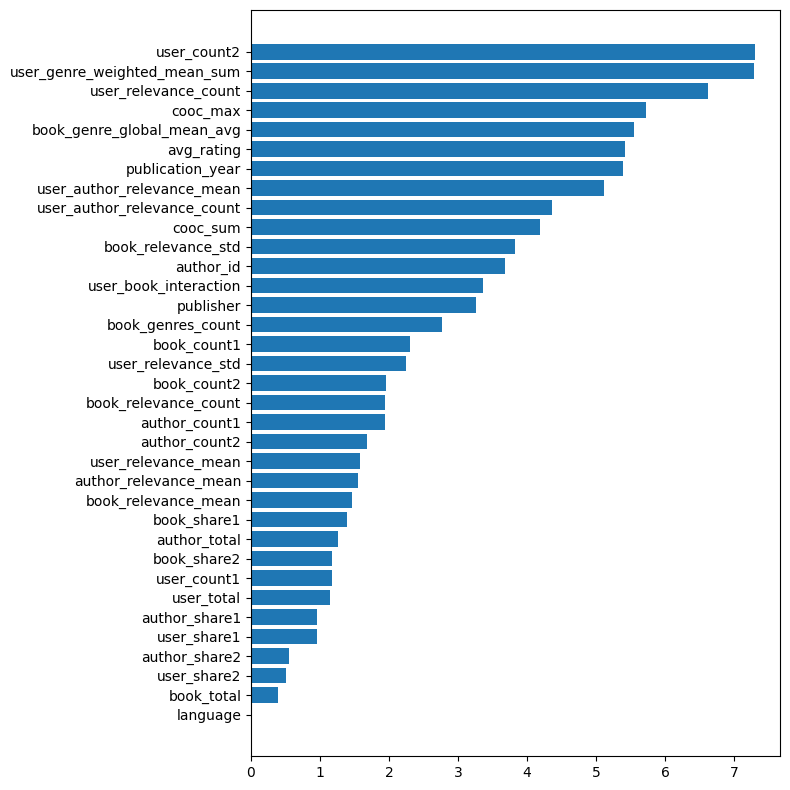

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 8)) 
plt.barh(y=[i[0] for i in imp_cols], width=[i[1] for i in imp_cols])
plt.tight_layout()

In [29]:
# Расширить candidates
candidates_pairs = expand_candidates(candidates_df)
candidates_pairs = candidates_pairs.merge(book_data_df, on='book_id', how="left")
candidates_pairs = create_full_features(candidates_pairs, train_df, book_genres_df, desc_df)

# Привести к нужным колонкам
for col in feature_cols:
    if col not in candidates_pairs.columns:
        candidates_pairs[col] = 0
        
X_test = candidates_pairs[feature_cols]
dropping = ['title', 'author_name']
X_test = X_test.drop(dropping, axis=1)

# Предсказать
scores = model.predict(X_test)
candidates_pairs["score"] = scores

# Ранжировать
submission_rows = []
for user_id in tqdm(targets_df['user_id']):
    user_df = candidates_pairs[candidates_pairs['user_id'] == user_id]
    if user_df.empty:
        book_list = ""
    else:
        top_k = user_df.nlargest(Cfg.MAX_RANKING_LENGTH, "score")
        book_list = ",".join(top_k['book_id'].astype(str))
    submission_rows.append({'user_id': user_id, 'book_id_list': book_list})

# Сохранить
sub_df = pd.DataFrame(submission_rows)
sub_df.to_csv('sub.csv', index=False)
print(f"Submission saved to sub.csv")

  0%|          | 0/3512 [00:00<?, ?it/s]

Submission saved to sub.csv
